In [54]:
! pip install forecast


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Part 1: Load and Prepare Data

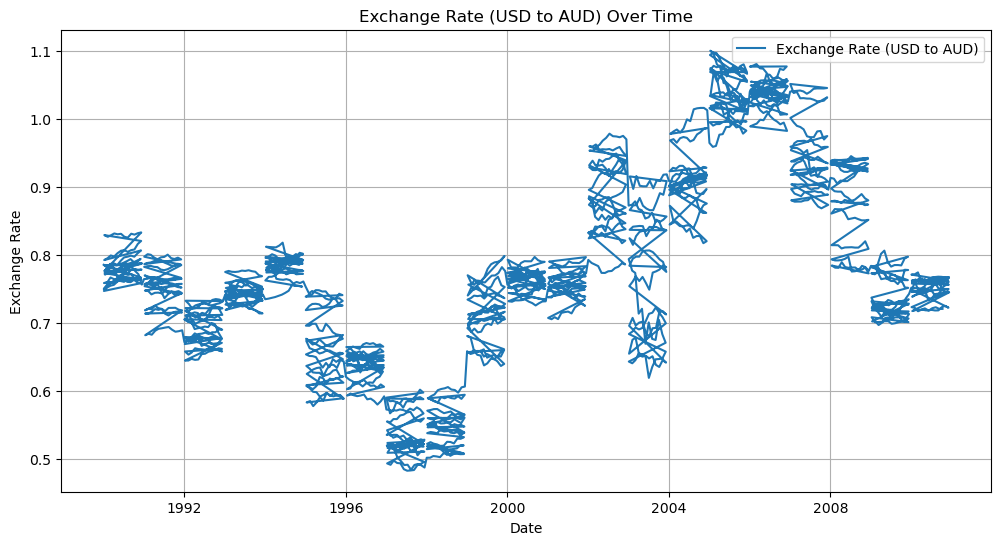

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(r"C:\Users\hp\Downloads\Timeseries\Timeseries\exchange_rate.csv")

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows where 'date' or 'Ex_rate' is NaN
df.dropna(subset=['date', 'Ex_rate'], inplace=True)

# Ensure 'Ex_rate' is numeric (some might be wrongly typed)
df['Ex_rate'] = pd.to_numeric(df['Ex_rate'], errors='coerce')
df.dropna(subset=['Ex_rate'], inplace=True)

# Set 'date' as the index for time series analysis
df.set_index('date', inplace=True)

# Plot the time series of exchange rate
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Exchange Rate based on Date')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exchange Rate (USD to AUD) Over Time')
plt.grid(True)
plt.legend()
plt.show()


Part 2: ARIMA Modeling

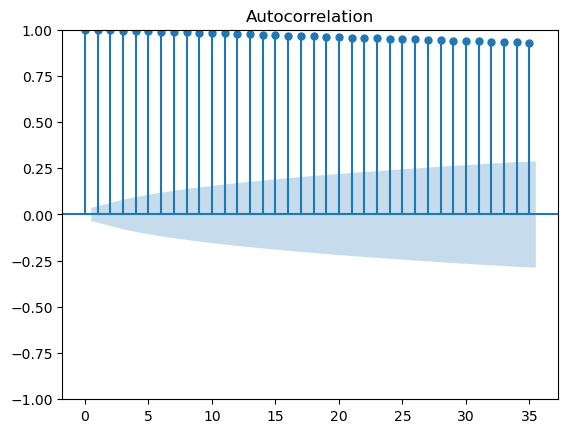

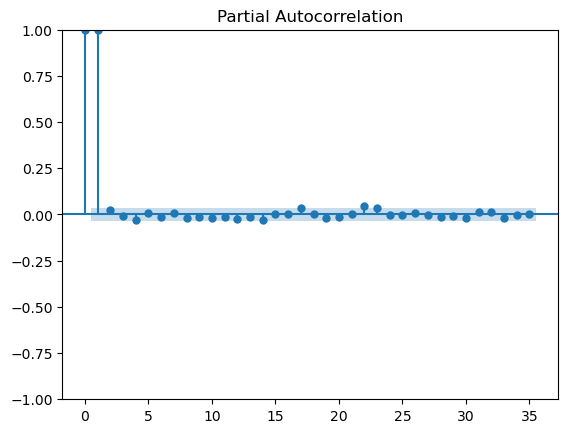

c:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda3\Lib\site-packages\statsm

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 2998
Model:                 ARIMA(1, 1, 1)   Log Likelihood               10144.297
Date:                Mon, 12 May 2025   AIC                         -20282.594
Time:                        16:53:47   BIC                         -20264.578
Sample:                             0   HQIC                        -20276.113
                               - 2998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0254      0.514     -0.049      0.961      -1.033       0.982
ma.L1         -0.0015      0.515     -0.003      0.998      -1.012       1.009
sigma2      6.722e-05   5.41e-07    124.264      0.0

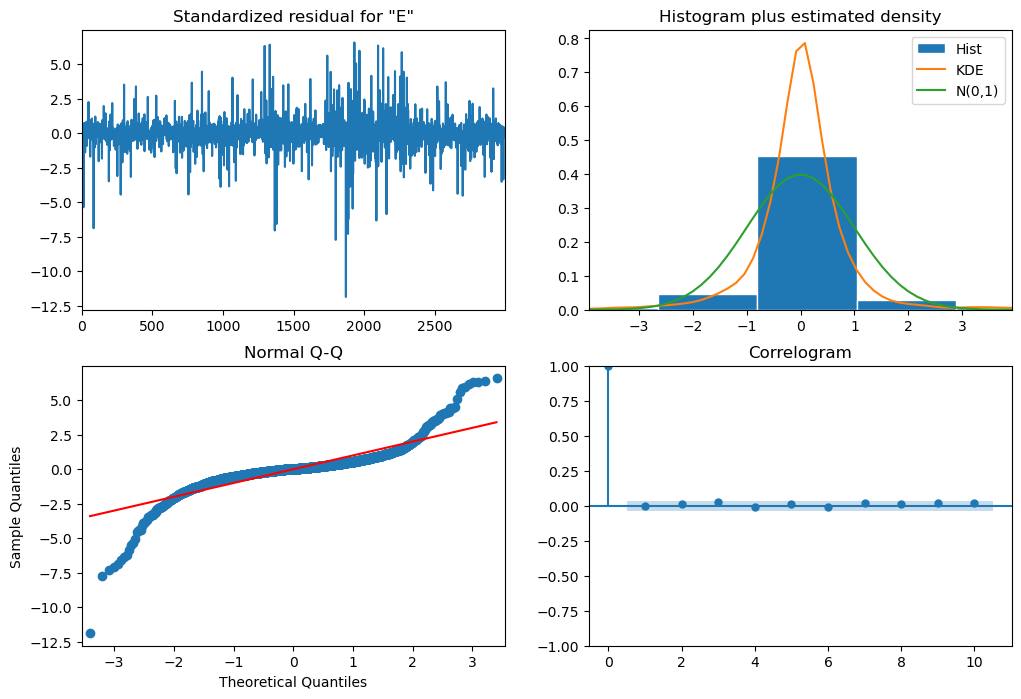

c:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


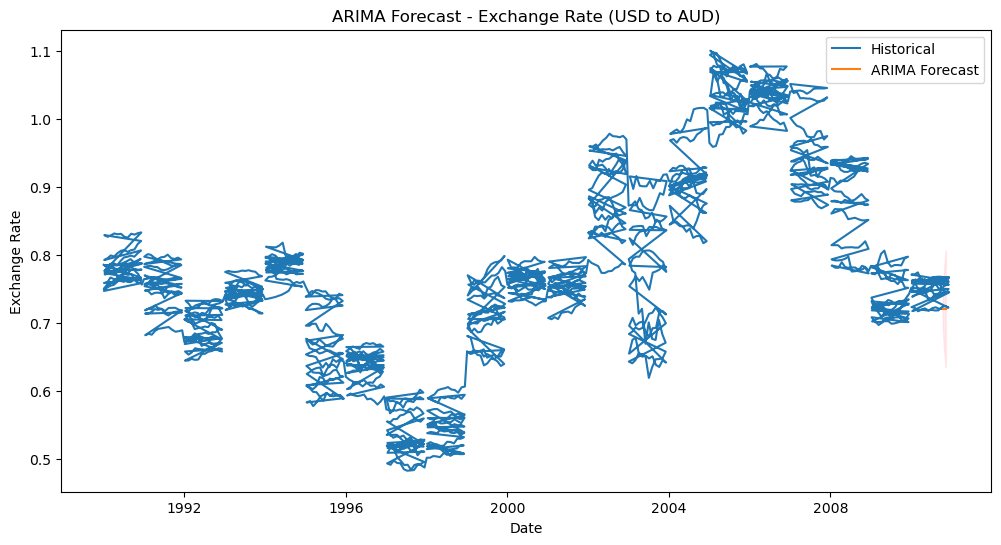

In [66]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# ACF & PACF to choose p, d, q
plot_acf(df['Ex_rate'])
plot_pacf(df['Ex_rate'])
plt.show()

# Fit ARIMA model (order (1, 1, 1) chosen based on ACF/PACF plots)
model = ARIMA(df['Ex_rate'], order=(1, 1, 1))
arima_result = model.fit()
print(arima_result.summary())

# Diagnostics plot
arima_result.plot_diagnostics(figsize=(12, 8))
plt.show()

# Forecasting
forecast = arima_result.get_forecast(steps=30)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Create datetime index for forecast
last_date = df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')
forecast_mean.index = forecast_index
forecast_ci.index = forecast_index

# Plot ARIMA Forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Historical')
plt.plot(forecast_mean, label='ARIMA Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('ARIMA Forecast - Exchange Rate (USD to AUD)')
plt.legend()
plt.show()


Part 3: Exponential Smoothing

c:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


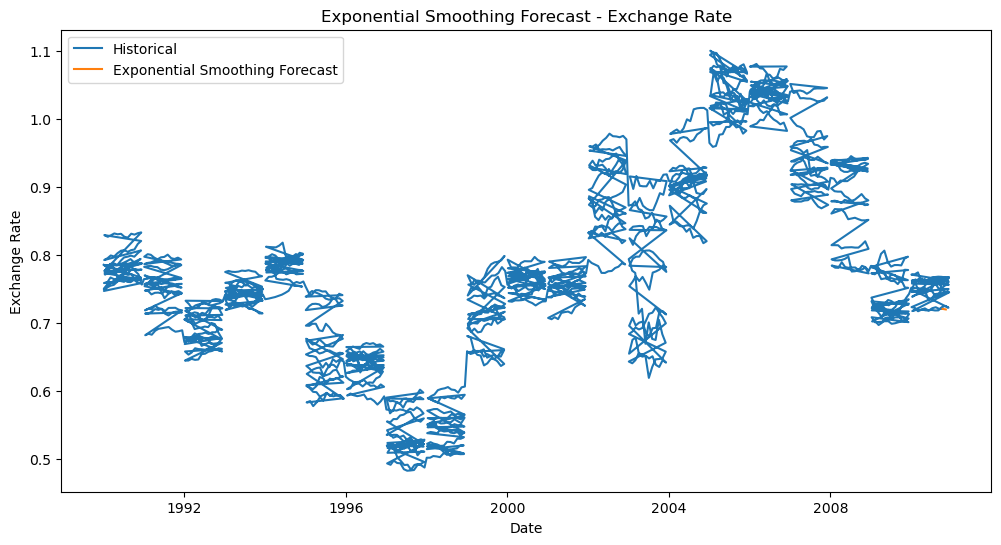

In [67]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Exponential Smoothing model
model_es = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None)
es_result = model_es.fit()

# Forecasting for next 30 days
es_forecast = es_result.forecast(30)

# Create index for ES forecast
es_forecast.index = forecast_index

# Plot Exponential Smoothing Forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Historical')
plt.plot(es_forecast, label='Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exponential Smoothing Forecast - Exchange Rate')
plt.legend()
plt.show()


Part 4: Evaluation and Comparison

In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Use last 30 values of actual data for comparison (adjust if available)
true_values = df['Ex_rate'][-30:]

# Trim forecasts to match true values length
arima_forecast = forecast_mean[:len(true_values)]
es_forecast = es_forecast[:len(true_values)]

# Compute evaluation metrics
mae_arima = mean_absolute_error(true_values, arima_forecast)
rmse_arima = mean_squared_error(true_values, arima_forecast, squared=False)

mae_es = mean_absolute_error(true_values, es_forecast)
rmse_es = mean_squared_error(true_values, es_forecast, squared=False)

print(f"ARIMA -> MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}")
print(f"Exponential Smoothing -> MAE: {mae_es:.4f}, RMSE: {rmse_es:.4f}")


ARIMA -> MAE: 0.0205, RMSE: 0.0258
Exponential Smoothing -> MAE: 0.0207, RMSE: 0.0260


c:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
